In [2]:
import time
import numpy as np
import pandas as pd
import tushare as ts
from talib.abstract import *

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.models import Sequential

In [1]:
import os
os.chdir('/Users/xupech/Desktop/brandeis graduate school/Academics/2020 SPRING/FIN 285 RISK SIMULATION/Final Project/Data')

In [3]:
# Read in SP500 Data.
df = pd.read_csv('./XLY.csv')

df.Date = pd.to_datetime(df.Date,format="%Y-%m-%d")
df = df.loc[df['Date'] < '2020-01-11']

df.tail(5)

# Volatility significant enough for analysis.
band_w = 0.8


In [5]:
df.Open.values

array([ 63.189999,  63.459999,  64.099998, ..., 125.870003, 127.029999,
       127.190002])

In [4]:
# Read in all bond index, currency, energy and metals and VIX data and use them as features to predict movement of the equity market.
bi = pd.read_csv('clean_bondindex.csv')
cur = pd.read_csv('clean_currency.csv')
em = pd.read_csv('clean_energy_metals.csv')
vix = pd.read_csv('VIX.csv')

# Combine all external data together into 1 dataframe.
ext_dt1 = bi.merge(cur, left_on='Date', right_on='Date') \
           .merge(em, left_on='Date', right_on='Date')

ext_dt = ext_dt1.iloc[::-1].reset_index(drop=True)

ext_dt.Date = pd.to_datetime(ext_dt.Date,format="%Y%m%d")

vix.Date = pd.to_datetime(vix.Date)
vix = vix.rename(columns={"Close": "vix"})

ext_dt = ext_dt.merge(vix, left_on = 'Date', right_on = 'Date')
ext_dt=ext_dt.drop(columns=['Open', 'High', 'Low','Adj Close', 'Volume'])

# Merge SP500 Data with external data.
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']] \
     .merge(ext_dt, left_on='Date', right_on='Date')
df.Volume = df.Volume.astype('double')

# Define inputs to be used by talib.
inputs = {
    'open': df.Open.values,
    'high': df.High.values,
    'low': df.Low.values,
    'close': df.Close.values,
    'volume': df.Volume.values
}

inputs.update(
    {key: df[key].values for key in df.columns[6:]}
)

# Use all technical indicators in talib for reference.
def ta_indicators(inputs):
    TAI_DICT = {
        'AD': AD(inputs),
        'ADD': ADD(inputs),
        'ATAN': ATAN(inputs),
        'AVGPRICE': AVGPRICE(inputs),
        'BOP': BOP(inputs),
        'CDL2CROWS': CDL2CROWS(inputs),
        'CDL3BLACKCROWS': CDL3BLACKCROWS(inputs),
        'CDL3INSIDE': CDL3INSIDE(inputs),
        'CDL3LINESTRIKE': CDL3LINESTRIKE(inputs),
        'CDL3OUTSIDE': CDL3OUTSIDE(inputs),
        'CDL3STARSINSOUTH': CDL3STARSINSOUTH(inputs),
        'CDL3WHITESOLDIERS': CDL3WHITESOLDIERS(inputs),
        'CDLADVANCEBLOCK': CDLADVANCEBLOCK(inputs),
        'CDLBELTHOLD': CDLBELTHOLD(inputs),
        'CDLBREAKAWAY': CDLBREAKAWAY(inputs),
        'CDLCLOSINGMARUBOZU': CDLCLOSINGMARUBOZU(inputs),
        'CDLCONCEALBABYSWALL': CDLCONCEALBABYSWALL(inputs),
        'CDLCOUNTERATTACK': CDLCOUNTERATTACK(inputs),
        'CDLDOJI': CDLDOJI(inputs),
        'CDLDOJISTAR': CDLDOJISTAR(inputs),
        'CDLDRAGONFLYDOJI': CDLDRAGONFLYDOJI(inputs),
        'CDLENGULFING': CDLENGULFING(inputs),
        'CDLGAPSIDESIDEWHITE': CDLGAPSIDESIDEWHITE(inputs),
        'CDLGRAVESTONEDOJI': CDLGRAVESTONEDOJI(inputs),
        'CDLHAMMER': CDLHAMMER(inputs),
        'CDLHANGINGMAN': CDLHANGINGMAN(inputs),
        'CDLHARAMI': CDLHARAMI(inputs),
        'CDLHARAMICROSS': CDLHARAMICROSS(inputs),
        'CDLHIGHWAVE': CDLHIGHWAVE(inputs),
        'CDLHIKKAKE': CDLHIKKAKE(inputs),
        'CDLHIKKAKEMOD': CDLHIKKAKEMOD(inputs),
        'CDLHOMINGPIGEON': CDLHOMINGPIGEON(inputs),
        'CDLIDENTICAL3CROWS': CDLIDENTICAL3CROWS(inputs),
        'CDLINNECK': CDLINNECK(inputs),
        'CDLINVERTEDHAMMER': CDLINVERTEDHAMMER(inputs),
        'CDLKICKING': CDLKICKING(inputs),
        'CDLKICKINGBYLENGTH': CDLKICKINGBYLENGTH(inputs),
        'CDLLADDERBOTTOM': CDLLADDERBOTTOM(inputs),
        'CDLLONGLEGGEDDOJI': CDLLONGLEGGEDDOJI(inputs),
        'CDLLONGLINE': CDLLONGLINE(inputs),
        'CDLMARUBOZU': CDLMARUBOZU(inputs),
        'CDLMATCHINGLOW': CDLMATCHINGLOW(inputs),
        'CDLONNECK': CDLONNECK(inputs),
        'CDLPIERCING': CDLPIERCING(inputs),
        'CDLRICKSHAWMAN': CDLRICKSHAWMAN(inputs),
        'CDLRISEFALL3METHODS': CDLRISEFALL3METHODS(inputs),
        'CDLSEPARATINGLINES': CDLSEPARATINGLINES(inputs),
        'CDLSHOOTINGSTAR': CDLSHOOTINGSTAR(inputs),
        'CDLSHORTLINE': CDLSHORTLINE(inputs),
        'CDLSPINNINGTOP': CDLSPINNINGTOP(inputs),
        'CDLSTALLEDPATTERN': CDLSTALLEDPATTERN(inputs),
        'CDLSTICKSANDWICH': CDLSTICKSANDWICH(inputs),
        'CDLTAKURI': CDLTAKURI(inputs),
        'CDLTASUKIGAP': CDLTASUKIGAP(inputs),
        'CDLTHRUSTING': CDLTHRUSTING(inputs),
        'CDLTRISTAR': CDLTRISTAR(inputs),
        'CDLUNIQUE3RIVER': CDLUNIQUE3RIVER(inputs),
        'CDLUPSIDEGAP2CROWS': CDLUPSIDEGAP2CROWS(inputs),
        'CDLXSIDEGAP3METHODS': CDLXSIDEGAP3METHODS(inputs),
        'CEIL': CEIL(inputs),
        'COS': COS(inputs),
        'COSH': COSH(inputs),

        'ATR': ATR(inputs, timeperiod=14),
        'BETA': BETA(inputs, timeperiod=5),
        'CCI': CCI(inputs, timeperiod=14),
        'CMO': CMO(inputs, timeperiod=14),
        'CORREL': CORREL(inputs, timeperiod=30),
        'ADX': ADX(inputs, timeperiod=14),
        'ADXR': ADXR(inputs, timeperiod=14),
        'AROONOSC': AROONOSC(inputs, timeperiod=14),
        'ADOSC': ADOSC(inputs, fastperiod=3, slowperiod=10),
        'APO': APO(inputs, fastperiod=12, slowperiod=26, matype=0),
        
        'MFI': MFI(inputs, timeperiod=14),
        'MINUS_DI' : MINUS_DI(inputs, timeperiod=14),
        'MINUS_DM' : MINUS_DM(inputs, timeperiod=14),
        'MOM' : MOM(inputs, timeperiod=10),
        'PLUS_DI' : PLUS_DI(inputs, timeperiod=14),
        'PLUS_DM' : PLUS_DM(inputs, timeperiod=14),
        'PRO' : PPO(inputs, fastperiod=12, slowperiod=26, matype=0),
        'ROC' : ROC(inputs, timeperiod=10),
        'ROCP' : ROCP(inputs, timeperiod=10),
        'ROCR' : ROCR(inputs, timeperiod=10),
        'ROCR100' : ROCR100(inputs, timeperiod=10),
        'RSI' : RSI(inputs, timeperiod=14),
        'TRIX' : TRIX(inputs, timeperiod=30),
        'ULTOSC' :ULTOSC(inputs, timeperiod1=7, timeperiod2=14, timeperiod3=28),
        'WILLR' : WILLR(inputs, timeperiod=14),
        
        'DEMA': DEMA(inputs, timeperiod=30),
        'EMA' : EMA(inputs, timeperiod=30),
        'HT_TRENDLINE' : HT_TRENDLINE(inputs),
        'KAMA' : KAMA(inputs, timeperiod=30),
        'MA' : MA(inputs, timeperiod=30, matype=0),
        'MIDPOINT' : MIDPOINT(inputs, timeperiod=14),
        'MIDPRICE' : MIDPRICE(inputs, timeperiod=14),
        'SAR' : SAR(inputs, acceleration=0, maximum=0),
        'SAREXT' : SAREXT(inputs, startvalue=0, offsetonreverse=0, accelerationinitlong=0,
                      accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, 
                      accelerationshort=0, accelerationmaxshort=0),
        'SMA' : SMA(inputs, timeperiod=30),
        'T3' : T3(inputs, timeperiod=5, vfactor=0),
        'TEMA' : TEMA(inputs, timeperiod=30),
        'TRIMA' : TRIMA(inputs, timeperiod=30),
        'WMA' : WMA(inputs, timeperiod=30),
        
        'OBV' : OBV(inputs),
        'NATR' : NATR(inputs, timeperiod=14),
        'TRANGE' : TRANGE(inputs),
        
        'HT_DCPERIOD' : HT_DCPERIOD(inputs),
        'HT_TRENDMODE' : HT_TRENDMODE(inputs),
        'HT_DCPHASE' : HT_DCPHASE(inputs),
        
        'LINEARREG' : LINEARREG(inputs, timeperiod=14),
        'LINEARREG_ANGLE' : LINEARREG_ANGLE(inputs, timeperiod=14),
        'LINEARREG_INTERCEPT' : LINEARREG_INTERCEPT(inputs, timeperiod=14),
        'LINEARREG_SLOPE' : LINEARREG_SLOPE(inputs, timeperiod=14),
        'STDDEV' : STDDEV(inputs, timeperiod=5, nbdev=1),
        
        'TYPPRICE' : TYPPRICE(inputs),
        'WCLPRICE' : WCLPRICE(inputs),
        
        'SINH' : SINH(inputs),
        'SQRT' : SQRT(inputs),
        'LOG10' : LOG10(inputs),
        
        
        'CDLABANDONEDBABY_0': CDLABANDONEDBABY(inputs, penetration=0),
        'CDLDARKCLOUDCOVER_0': CDLDARKCLOUDCOVER(inputs, penetration=0),
        'CDLEVENINGDOJISTAR_0': CDLEVENINGDOJISTAR(inputs, penetration=0),
        'CDLEVENINGSTAR_0': CDLEVENINGSTAR(inputs, penetration=0),
        'CDLMATHOLD_0': CDLMATHOLD(inputs, penetration=0),
        'CDLMORNINGDOJISTAR_0': CDLMORNINGDOJISTAR(inputs, penetration=0),
        'CDLMORNINGSTAR_0': CDLMORNINGSTAR(inputs, penetration=0),

        'CDLABANDONEDBABY_3': CDLABANDONEDBABY(inputs, penetration=0.3),
        'CDLDARKCLOUDCOVER_3': CDLDARKCLOUDCOVER(inputs, penetration=0.3),
        'CDLEVENINGDOJISTAR_3': CDLEVENINGDOJISTAR(inputs, penetration=0.3),
        'CDLEVENINGSTAR_3': CDLEVENINGSTAR(inputs, penetration=0.3),
        'CDLMATHOLD_3': CDLMATHOLD(inputs, penetration=0.3),
        'CDLMORNINGDOJISTAR_3': CDLMORNINGDOJISTAR(inputs, penetration=0.3),
        'CDLMORNINGSTAR_3': CDLMORNINGSTAR(inputs, penetration=0.3),

        'CDLABANDONEDBABY_5': CDLABANDONEDBABY(inputs, penetration=0.5),
        'CDLDARKCLOUDCOVER_5': CDLDARKCLOUDCOVER(inputs, penetration=0.5),
        'CDLEVENINGDOJISTAR_5': CDLEVENINGDOJISTAR(inputs, penetration=0.5),
        'CDLEVENINGSTAR_5': CDLEVENINGSTAR(inputs, penetration=0.5),
        'CDLMATHOLD_5': CDLMATHOLD(inputs, penetration=0.5),
        'CDLMORNINGDOJISTAR_5': CDLMORNINGDOJISTAR(inputs, penetration=0.5),
        'CDLMORNINGSTAR_5': CDLMORNINGSTAR(inputs, penetration=0.5),
    }

    inphase, quadrature = HT_PHASOR(inputs)
    sine, leadsine = HT_SINE(inputs)
    macd_macd, macd_macdsignal, macd_macdhist = MACD(inputs,fastperiod=12, slowperiod=26,signalperiod=9)
    macdext_macd, macdext_macdsignal, macdext_macdhist = MACDEXT(inputs, fastperiod=12, fastmatype=0, slowperiod=26, 
                                                                 slowmatype=0, signalperiod=9, signalmatype=0)
    macdfix_macd, macdfix_macdsignal, macdfix_macdhist = MACDFIX(inputs, signalperiod=9)
    slowk, slowd = STOCH(inputs, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    fastk, fastd = STOCHF(inputs, fastk_period=5, fastd_period=3, fastd_matype=0)
    fastk_rsi, fastd_rsi = STOCHRSI(inputs, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    bu, bm, bl = BBANDS(inputs, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    ad, au = AROON(inputs, timeperiod=14)


    TAI_DICT.update({'BBANDS_UPPERBAND': bu, 'BBANDS_MIDDLEBAND': bm, 'BBANDS_LOWERBAND': bl, 
                     'AROONDOWN': ad, 'AROONUP': au,
                     'HT_PHASOR_INPHASE': inphase, 'HT_PHASOR_QUADRATURE': quadrature,
                     'HT_SINE_SINE': sine, 'HT_SINE_SINE': leadsine,
                     'MACD_MACD': macd_macd, 'MACD_MACDSIGNAL': macd_macdsignal, 'MACD_MACDHIS': macd_macdhist,
                     'MACDEXT_MACD': macdext_macd, 'MACDEXT_MACDSIGNAL': macdext_macdsignal, 'MACDEXT_MACDHIS': macdext_macdhist,
                     'MACDFIX_MACD': macdfix_macd, 'MACDFIX_MACDSIGNAL': macdfix_macdsignal, 'MACDFIX_MACDHIS': macdfix_macdhist,
                     'STOCH_SLOWK': slowk, 'STOCH_SLOWD': slowd,
                     'STOCHF_FASTK': fastk, 'STOCHF_FASTD': fastd, 
                     'STOCHRSI_FASTK': fastk_rsi, 'STOCHRSI_FASTD': fastd_rsi
    })

    return TAI_DICT

# Calculate all technical indicators.
TAI_DICT = ta_indicators(inputs)

# Go back to 1 day prediction.
df_inputs = pd.concat([pd.DataFrame(inputs), pd.DataFrame(TAI_DICT)], axis=1)
df_inputs = df_inputs
for col in df_inputs.columns:
    if len(np.unique(df_inputs[col].dropna())) == 1:
        df_inputs.drop(columns=col, inplace=True)


df_inputs['close_y'] = (-(df['Close'] - df['Close'].shift(-1)) \
                        / df['Close'] * 100)

df_inputs['close_y'] = df_inputs['close_y'] * 1.0

df_inputs.dropna(inplace=True)

In [ ]:
train_per = 0.82

X = df_inputs[df_inputs.columns[:-1]].values
y = df_inputs[df_inputs.columns[-1]].values

num_feature = X.shape[1]
print('number of features: ', num_feature)

train_size = int(len(X) * train_per)
test_size = len(X) - train_size
X_train_set, X_test_set = X[0:train_size,:], X[train_size:len(X),:]
y_train_set, y_test_set = y[0:train_size], y[train_size:len(y)]

print('length of X_train_set: %s\nlength of X_test_set: %s'%(len(X_train_set), len(X_test_set)))

scaler = StandardScaler().fit(X_train_set)
X_train_set = scaler.transform(X_train_set)
X_test_set = scaler.transform(X_test_set)

pc = 60
pca = PCA(n_components=pc, svd_solver='full')
pca.fit(X_train_set)

X_train_set = pca.transform(X_train_set)
X_test_set = pca.transform(X_test_set)

print('number of PCs: ', pc)
print(sum(pca.explained_variance_ratio_[:pc]))

# Look 5 day before and use 0.5% again as a threshold to determine price movement is significant.
need_num = 5

y_train = np.asarray(y_train_set[need_num:])
y_test = np.asarray(y_test_set[need_num:])

X_train = []
for i in range(need_num, len(X_train_set)):
    if abs(y_train[i-need_num]) > band_w:
        X_train.append(X_train_set[i-need_num:i])
y_train = y_train[abs(y_train) > band_w] 

X_train = np.asarray(np.array(X_train))
input_shape = X_train.shape
print('shape of X_train: (%s, %s, %s)'%input_shape)

X_test = []
for i in range(need_num, len(X_test_set)):
    if abs(y_test[i-need_num]) > band_w:
        X_test.append(X_test_set[i-need_num:i])
X_test = np.asarray(np.array(X_test))
y_test = y_test[abs(y_test) > band_w] 
print('shape of X_test: (%s, %s, %s)'%X_test.shape)


print('shape of y_train: (%s,)'%y_train.shape)
print('shape of y_test: (%s,)'%y_test.shape)

dropout_rate = 0.45

model = Sequential()

model.add(LSTM(units=16, return_sequences=True))
model.add(Dropout(rate=dropout_rate))
model.add(LSTM(units=8, return_sequences=False))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(units=8))
model.add(Activation("relu"))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(units=1))
model.add(Activation("linear"))
rms=optimizers.RMSprop(lr=2e-3, rho=0.9, epsilon=1e-06)

start = time.time()
model.compile(loss="mse", optimizer=rms)
print ('compilation time : ', time.time() - start)

model.fit(x=X_train, y=(y_train), epochs=100, batch_size=30)

plt.subplots(figsize=(16,5))
plt.plot(range(y_train.shape[0]), model.predict(x=X_train).reshape(-1), label='Predicted', c='black')
plt.plot(range(y_train.shape[0]), y_train, label='Real', c='gray')
plt.plot(range(y_train.shape[0]), [0]*len(y_train), c='gray')
plt.title('Predicted Price Movement In Training Data')
plt.legend()
plt.show()

y_pred = model.predict(x=X_test).reshape(-1)
plt.subplots(figsize=(16,5))
plt.plot(range(y_test.shape[0]), y_pred, label='Predicted', c='black')
plt.plot(range(y_test.shape[0]), y_test, label='Real', c='gray')
plt.plot(range(y_test.shape[0]), [0]*len(y_test), c='gray')
plt.title('Predicted Price Movement In Test Data (Volatility >' +str(band_w)+' Only)')
plt.legend()
plt.show()

y_test = np.asarray(y_test_set[need_num:])

X_test = []
for i in range(need_num, len(X_test_set)):
    X_test.append(X_test_set[i-need_num:i])
X_test = np.asarray(np.array(X_test))

print('shape of X_test: (%s, %s, %s)'%X_test.shape)
print('shape of y_test: (%s,)'%y_test.shape)

y_pred = model.predict(x=X_test).reshape(-1)
plt.subplots(figsize=(16,5))
plt.plot(range(y_test.shape[0]), y_pred, label='Predicted', c='black')
plt.plot(range(y_test.shape[0]), y_test, label='Real', c='gray')
plt.plot(range(y_test.shape[0]), [0]*len(y_test), c='gray')
plt.title('Predicted Price Movement In Test Data')
plt.legend()
plt.show()

y_pred = model.predict(x=X_test).reshape(-1)
y_pred.shape

In [240]:
# All sub sectors price prediction stored in alldirection dataframe.
#alldirection = pd.DataFrame({'rwrd': rwrd, 'xlbd': xlbd, 'xled': xled,'xlfd': xlfd,'xlid': xlid,'xlkd': xlkd, 'xlpd': xlpd, 
#              'xlud':xlud,'xlvd': xlvd,'xlyd': xlyd})
#alldirection.to_csv('alldirection.csv')

In [276]:
# All sub sectors close price stored in allclose dataframe.
#allclose = pd.DataFrame({'rwrc': rwrc, 'xlbc': xlbc, 'xlec': xlec,'xlfc': xlfc,'xlic': xlic,'xlkc': xlkc, 'xlpc': xlpc, 
#              'xluc':xluc,'xlvc': xlvc,'xlyc': xlyc})
#allclose.to_csv('allclose.csv')

## BACK TEST

In [122]:
def read_volatility(path):
    vol = pd.read_csv(path)
    vol= vol[:-1]
    vol.tail(15)
    volatility = vol[155:]
    volatility=volatility.iloc[:,-1].values
    return volatility

In [366]:
# All predicted volatility.
xluv = read_volatility('XLU_V.csv')
rwrv = read_volatility('RWR_V.csv')
xlbv = read_volatility('XLB_V.csv')
xlev = read_volatility('XLE_V.csv')
xlfv = read_volatility('XLF_V.csv')
xliv = read_volatility('XLI_V.csv')
xlkv = read_volatility('XLK_V.csv')
xlpv = read_volatility('XLP_V.csv')
xlvv = read_volatility('XLV_V.csv')
xlyv = read_volatility('XLY_V.csv')

# All predicted price movement.
alldirection = pd.read_csv('alldirection.csv')
rwrd = alldirection.rwrd.values
xlbd = alldirection.xlbd.values
xled = alldirection.xled.values
xlfd = alldirection.xlfd.values
xlid = alldirection.xlid.values
xlkd = alldirection.xlkd.values
xlpd = alldirection.xlpd.values
xlud = alldirection.xlud.values
xlvd = alldirection.xlvd.values
xlyd = alldirection.xlyd.values

# All close price.
allclose = pd.read_csv('allclose.csv')
rwrc = allclose.rwrc.values
xlbc = allclose.xlbc.values
xlec = allclose.xlec.values
xlfc = allclose.xlfc.values
xlic = allclose.xlic.values
xlkc = allclose.xlkc.values
xlpc = allclose.xlpc.values
xluc = allclose.xluc.values
xlvc = allclose.xlvc.values
xlyc = allclose.xlyc.values

In [367]:
acp = [rwrc,xlbc,xlec,xlfc,xlic,xlkc,xlpc,xluc,xlvc,xlyc]
apm = [rwrd,xlbd,xled,xlfd,xlid,xlkd,xlpd,xlud,xlvd,xlyd]
apv = [rwrv,xlbv,xlev,xlfv,xliv,xlkv,xlpv,xluv,xlvv,xlyv]

10

In [ ]:
# Back test functions.

# Given prediction of volatility and price direction movement, we will execute the following strategy.

def action(volatility, direction):
    position = []
    share = 0
    flag = False
    for i in range(len(volatility)):
        if volatility[i] == False:
            if direction[i]>0:
                if not flag:
                    flag = True
                    position.append(100)
                    share +=100
                else:
                    flag = True
                    position.append(0)
                        
            else:
                if not flag:
                    flag = True
                    position.append(-100)
                    share -=100
                else:
                    flag = True
                    position.append(0)
        else:
            if flag:
                position.append(-share)
                flag = False
                share = 0
            else:
                position.append(0)
    return position

# strategy return given trading executions above.

def load_strategy(_hist, position):
    strategy =[]
    pool = 0
    share = 0
    totalret = 0
    totalposition = 0
    ret = 0
    
    flag = False
    for i in range(len(position)):
        strategy.append(totalret)
        if flag == False:
            if position[i]==0:
                flag = False
            else:
                pool = position[i] * _hist[i]
                share = position [i]
                totalposition += abs(share)
                flag = True

        else:
            if position[i] == 0:
                dayret = (_hist[i]*share - pool)/pool
                totalret = dayret*abs(pool)/(abs(pool)+totalposition)+ret*totalposition/(abs(pool)+totalposition)
            else:
                dayret = (_hist[i]*share - pool)/pool
                totalret = dayret*abs(pool)/(abs(pool)+totalposition)+ret*totalposition/(abs(pool)+totalposition)
                ret = totalret 
                flag = False
    return strategy

In [369]:
acp = [rwrc,xlbc,xlec,xlfc,xlic,xlkc,xlpc,xluc,xlvc,xlyc]
apm = [rwrd,xlbd,xled,xlfd,xlid,xlkd,xlpd,xlud,xlvd,xlyd]
apv = [rwrv,xlbv,xlev,xlfv,xliv,xlkv,xlpv,xluv,xlvv,xlyv]

def all_ret(accp, appm, appv):
    ret = []
    for i in range(len(accp)):
        closeprice = accp[i]
        position = action(appv[i], appm[i])
        ret.append(np.array(load_strategy(closeprice, position)))
    return ret

In [341]:
# Weighted return adding up all executions of sub sectors.
m = all_ret(acp, apm, apv)
allret = (m[0]+m[1]+m[2]+m[3]+m[4]+m[5]+m[6]+m[7]+m[8]+m[9])/10

In [348]:
# Read in SP500 Data and compute benchmark return.
df = pd.read_csv('./sp500.csv')

df.Date = pd.to_datetime(df.Date,format="%Y-%m-%d")
df = df.loc[df['Date'] < '2020-01-11']

df.tail(5)

band_w = 0.8

# Read in all bond index, currency, energy and metals and VIX data and use them as features to predict movement of the equity market.
bi = pd.read_csv('clean_bondindex.csv')
cur = pd.read_csv('clean_currency.csv')
em = pd.read_csv('clean_energy_metals.csv')
vix = pd.read_csv('VIX.csv')

# Combine all external data together into 1 dataframe.
ext_dt1 = bi.merge(cur, left_on='Date', right_on='Date') \
           .merge(em, left_on='Date', right_on='Date')

ext_dt = ext_dt1.iloc[::-1].reset_index(drop=True)

ext_dt.Date = pd.to_datetime(ext_dt.Date,format="%Y%m%d")

vix.Date = pd.to_datetime(vix.Date)
vix = vix.rename(columns={"Close": "vix"})

ext_dt = ext_dt.merge(vix, left_on = 'Date', right_on = 'Date')
ext_dt=ext_dt.drop(columns=['Open', 'High', 'Low','Adj Close', 'Volume'])

# Merge SP500 Data with external data.
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']] \
     .merge(ext_dt, left_on='Date', right_on='Date')
df.Volume = df.Volume.astype('double')

# Define inputs to be used by talib.
inputs = {
    'open': df.Open.values,
    'high': df.High.values,
    'low': df.Low.values,
    'close': df.Close.values,
    'volume': df.Volume.values
}

inputs.update(
    {key: df[key].values for key in df.columns[6:]}
)

# Use all technical indicators in talib for reference.
def ta_indicators(inputs):
    TAI_DICT = {
        'AD': AD(inputs),
        'ADD': ADD(inputs),
        'ATAN': ATAN(inputs),
        'AVGPRICE': AVGPRICE(inputs),
        'BOP': BOP(inputs),
        'CDL2CROWS': CDL2CROWS(inputs),
        'CDL3BLACKCROWS': CDL3BLACKCROWS(inputs),
        'CDL3INSIDE': CDL3INSIDE(inputs),
        'CDL3LINESTRIKE': CDL3LINESTRIKE(inputs),
        'CDL3OUTSIDE': CDL3OUTSIDE(inputs),
        'CDL3STARSINSOUTH': CDL3STARSINSOUTH(inputs),
        'CDL3WHITESOLDIERS': CDL3WHITESOLDIERS(inputs),
        'CDLADVANCEBLOCK': CDLADVANCEBLOCK(inputs),
        'CDLBELTHOLD': CDLBELTHOLD(inputs),
        'CDLBREAKAWAY': CDLBREAKAWAY(inputs),
        'CDLCLOSINGMARUBOZU': CDLCLOSINGMARUBOZU(inputs),
        'CDLCONCEALBABYSWALL': CDLCONCEALBABYSWALL(inputs),
        'CDLCOUNTERATTACK': CDLCOUNTERATTACK(inputs),
        'CDLDOJI': CDLDOJI(inputs),
        'CDLDOJISTAR': CDLDOJISTAR(inputs),
        'CDLDRAGONFLYDOJI': CDLDRAGONFLYDOJI(inputs),
        'CDLENGULFING': CDLENGULFING(inputs),
        'CDLGAPSIDESIDEWHITE': CDLGAPSIDESIDEWHITE(inputs),
        'CDLGRAVESTONEDOJI': CDLGRAVESTONEDOJI(inputs),
        'CDLHAMMER': CDLHAMMER(inputs),
        'CDLHANGINGMAN': CDLHANGINGMAN(inputs),
        'CDLHARAMI': CDLHARAMI(inputs),
        'CDLHARAMICROSS': CDLHARAMICROSS(inputs),
        'CDLHIGHWAVE': CDLHIGHWAVE(inputs),
        'CDLHIKKAKE': CDLHIKKAKE(inputs),
        'CDLHIKKAKEMOD': CDLHIKKAKEMOD(inputs),
        'CDLHOMINGPIGEON': CDLHOMINGPIGEON(inputs),
        'CDLIDENTICAL3CROWS': CDLIDENTICAL3CROWS(inputs),
        'CDLINNECK': CDLINNECK(inputs),
        'CDLINVERTEDHAMMER': CDLINVERTEDHAMMER(inputs),
        'CDLKICKING': CDLKICKING(inputs),
        'CDLKICKINGBYLENGTH': CDLKICKINGBYLENGTH(inputs),
        'CDLLADDERBOTTOM': CDLLADDERBOTTOM(inputs),
        'CDLLONGLEGGEDDOJI': CDLLONGLEGGEDDOJI(inputs),
        'CDLLONGLINE': CDLLONGLINE(inputs),
        'CDLMARUBOZU': CDLMARUBOZU(inputs),
        'CDLMATCHINGLOW': CDLMATCHINGLOW(inputs),
        'CDLONNECK': CDLONNECK(inputs),
        'CDLPIERCING': CDLPIERCING(inputs),
        'CDLRICKSHAWMAN': CDLRICKSHAWMAN(inputs),
        'CDLRISEFALL3METHODS': CDLRISEFALL3METHODS(inputs),
        'CDLSEPARATINGLINES': CDLSEPARATINGLINES(inputs),
        'CDLSHOOTINGSTAR': CDLSHOOTINGSTAR(inputs),
        'CDLSHORTLINE': CDLSHORTLINE(inputs),
        'CDLSPINNINGTOP': CDLSPINNINGTOP(inputs),
        'CDLSTALLEDPATTERN': CDLSTALLEDPATTERN(inputs),
        'CDLSTICKSANDWICH': CDLSTICKSANDWICH(inputs),
        'CDLTAKURI': CDLTAKURI(inputs),
        'CDLTASUKIGAP': CDLTASUKIGAP(inputs),
        'CDLTHRUSTING': CDLTHRUSTING(inputs),
        'CDLTRISTAR': CDLTRISTAR(inputs),
        'CDLUNIQUE3RIVER': CDLUNIQUE3RIVER(inputs),
        'CDLUPSIDEGAP2CROWS': CDLUPSIDEGAP2CROWS(inputs),
        'CDLXSIDEGAP3METHODS': CDLXSIDEGAP3METHODS(inputs),
        'CEIL': CEIL(inputs),
        'COS': COS(inputs),
        'COSH': COSH(inputs),

        'ATR': ATR(inputs, timeperiod=14),
        'BETA': BETA(inputs, timeperiod=5),
        'CCI': CCI(inputs, timeperiod=14),
        'CMO': CMO(inputs, timeperiod=14),
        'CORREL': CORREL(inputs, timeperiod=30),
        'ADX': ADX(inputs, timeperiod=14),
        'ADXR': ADXR(inputs, timeperiod=14),
        'AROONOSC': AROONOSC(inputs, timeperiod=14),
        'ADOSC': ADOSC(inputs, fastperiod=3, slowperiod=10),
        'APO': APO(inputs, fastperiod=12, slowperiod=26, matype=0),
        
        'MFI': MFI(inputs, timeperiod=14),
        'MINUS_DI' : MINUS_DI(inputs, timeperiod=14),
        'MINUS_DM' : MINUS_DM(inputs, timeperiod=14),
        'MOM' : MOM(inputs, timeperiod=10),
        'PLUS_DI' : PLUS_DI(inputs, timeperiod=14),
        'PLUS_DM' : PLUS_DM(inputs, timeperiod=14),
        'PRO' : PPO(inputs, fastperiod=12, slowperiod=26, matype=0),
        'ROC' : ROC(inputs, timeperiod=10),
        'ROCP' : ROCP(inputs, timeperiod=10),
        'ROCR' : ROCR(inputs, timeperiod=10),
        'ROCR100' : ROCR100(inputs, timeperiod=10),
        'RSI' : RSI(inputs, timeperiod=14),
        'TRIX' : TRIX(inputs, timeperiod=30),
        'ULTOSC' :ULTOSC(inputs, timeperiod1=7, timeperiod2=14, timeperiod3=28),
        'WILLR' : WILLR(inputs, timeperiod=14),
        
        'DEMA': DEMA(inputs, timeperiod=30),
        'EMA' : EMA(inputs, timeperiod=30),
        'HT_TRENDLINE' : HT_TRENDLINE(inputs),
        'KAMA' : KAMA(inputs, timeperiod=30),
        'MA' : MA(inputs, timeperiod=30, matype=0),
        'MIDPOINT' : MIDPOINT(inputs, timeperiod=14),
        'MIDPRICE' : MIDPRICE(inputs, timeperiod=14),
        'SAR' : SAR(inputs, acceleration=0, maximum=0),
        'SAREXT' : SAREXT(inputs, startvalue=0, offsetonreverse=0, accelerationinitlong=0,
                      accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, 
                      accelerationshort=0, accelerationmaxshort=0),
        'SMA' : SMA(inputs, timeperiod=30),
        'T3' : T3(inputs, timeperiod=5, vfactor=0),
        'TEMA' : TEMA(inputs, timeperiod=30),
        'TRIMA' : TRIMA(inputs, timeperiod=30),
        'WMA' : WMA(inputs, timeperiod=30),
        
        'OBV' : OBV(inputs),
        'NATR' : NATR(inputs, timeperiod=14),
        'TRANGE' : TRANGE(inputs),
        
        'HT_DCPERIOD' : HT_DCPERIOD(inputs),
        'HT_TRENDMODE' : HT_TRENDMODE(inputs),
        'HT_DCPHASE' : HT_DCPHASE(inputs),
        
        'LINEARREG' : LINEARREG(inputs, timeperiod=14),
        'LINEARREG_ANGLE' : LINEARREG_ANGLE(inputs, timeperiod=14),
        'LINEARREG_INTERCEPT' : LINEARREG_INTERCEPT(inputs, timeperiod=14),
        'LINEARREG_SLOPE' : LINEARREG_SLOPE(inputs, timeperiod=14),
        'STDDEV' : STDDEV(inputs, timeperiod=5, nbdev=1),
        
        'TYPPRICE' : TYPPRICE(inputs),
        'WCLPRICE' : WCLPRICE(inputs),
        
        'SINH' : SINH(inputs),
        'SQRT' : SQRT(inputs),
        'LOG10' : LOG10(inputs),
        
        
        'CDLABANDONEDBABY_0': CDLABANDONEDBABY(inputs, penetration=0),
        'CDLDARKCLOUDCOVER_0': CDLDARKCLOUDCOVER(inputs, penetration=0),
        'CDLEVENINGDOJISTAR_0': CDLEVENINGDOJISTAR(inputs, penetration=0),
        'CDLEVENINGSTAR_0': CDLEVENINGSTAR(inputs, penetration=0),
        'CDLMATHOLD_0': CDLMATHOLD(inputs, penetration=0),
        'CDLMORNINGDOJISTAR_0': CDLMORNINGDOJISTAR(inputs, penetration=0),
        'CDLMORNINGSTAR_0': CDLMORNINGSTAR(inputs, penetration=0),

        'CDLABANDONEDBABY_3': CDLABANDONEDBABY(inputs, penetration=0.3),
        'CDLDARKCLOUDCOVER_3': CDLDARKCLOUDCOVER(inputs, penetration=0.3),
        'CDLEVENINGDOJISTAR_3': CDLEVENINGDOJISTAR(inputs, penetration=0.3),
        'CDLEVENINGSTAR_3': CDLEVENINGSTAR(inputs, penetration=0.3),
        'CDLMATHOLD_3': CDLMATHOLD(inputs, penetration=0.3),
        'CDLMORNINGDOJISTAR_3': CDLMORNINGDOJISTAR(inputs, penetration=0.3),
        'CDLMORNINGSTAR_3': CDLMORNINGSTAR(inputs, penetration=0.3),

        'CDLABANDONEDBABY_5': CDLABANDONEDBABY(inputs, penetration=0.5),
        'CDLDARKCLOUDCOVER_5': CDLDARKCLOUDCOVER(inputs, penetration=0.5),
        'CDLEVENINGDOJISTAR_5': CDLEVENINGDOJISTAR(inputs, penetration=0.5),
        'CDLEVENINGSTAR_5': CDLEVENINGSTAR(inputs, penetration=0.5),
        'CDLMATHOLD_5': CDLMATHOLD(inputs, penetration=0.5),
        'CDLMORNINGDOJISTAR_5': CDLMORNINGDOJISTAR(inputs, penetration=0.5),
        'CDLMORNINGSTAR_5': CDLMORNINGSTAR(inputs, penetration=0.5),
    }

    inphase, quadrature = HT_PHASOR(inputs)
    sine, leadsine = HT_SINE(inputs)
    macd_macd, macd_macdsignal, macd_macdhist = MACD(inputs,fastperiod=12, slowperiod=26,signalperiod=9)
    macdext_macd, macdext_macdsignal, macdext_macdhist = MACDEXT(inputs, fastperiod=12, fastmatype=0, slowperiod=26, 
                                                                 slowmatype=0, signalperiod=9, signalmatype=0)
    macdfix_macd, macdfix_macdsignal, macdfix_macdhist = MACDFIX(inputs, signalperiod=9)
    slowk, slowd = STOCH(inputs, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    fastk, fastd = STOCHF(inputs, fastk_period=5, fastd_period=3, fastd_matype=0)
    fastk_rsi, fastd_rsi = STOCHRSI(inputs, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    bu, bm, bl = BBANDS(inputs, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    ad, au = AROON(inputs, timeperiod=14)


    TAI_DICT.update({'BBANDS_UPPERBAND': bu, 'BBANDS_MIDDLEBAND': bm, 'BBANDS_LOWERBAND': bl, 
                     'AROONDOWN': ad, 'AROONUP': au,
                     'HT_PHASOR_INPHASE': inphase, 'HT_PHASOR_QUADRATURE': quadrature,
                     'HT_SINE_SINE': sine, 'HT_SINE_SINE': leadsine,
                     'MACD_MACD': macd_macd, 'MACD_MACDSIGNAL': macd_macdsignal, 'MACD_MACDHIS': macd_macdhist,
                     'MACDEXT_MACD': macdext_macd, 'MACDEXT_MACDSIGNAL': macdext_macdsignal, 'MACDEXT_MACDHIS': macdext_macdhist,
                     'MACDFIX_MACD': macdfix_macd, 'MACDFIX_MACDSIGNAL': macdfix_macdsignal, 'MACDFIX_MACDHIS': macdfix_macdhist,
                     'STOCH_SLOWK': slowk, 'STOCH_SLOWD': slowd,
                     'STOCHF_FASTK': fastk, 'STOCHF_FASTD': fastd, 
                     'STOCHRSI_FASTK': fastk_rsi, 'STOCHRSI_FASTD': fastd_rsi
    })

    return TAI_DICT

# Calculate all technical indicators.
TAI_DICT = ta_indicators(inputs)

# Go back to 1 day prediction.
df_inputs = pd.concat([pd.DataFrame(inputs), pd.DataFrame(TAI_DICT)], axis=1)
df_inputs = df_inputs
for col in df_inputs.columns:
    if len(np.unique(df_inputs[col].dropna())) == 1:
        df_inputs.drop(columns=col, inplace=True)


df_inputs['close_y'] = (-(df['Close'] - df['Close'].shift(-1)) \
                        / df['Close'] * 100)

df_inputs['close_y'] = df_inputs['close_y'] * 1.0

df_inputs.dropna(inplace=True)

spc=df_inputs.close.values[-235:]

In [363]:
# Show results on plot.
def show_results(btsp, portfolio):
    plt.subplots(figsize=(16,5))
    plt.plot(range(len(btsp)), 
                [(btsp[i]/btsp[0]-1) for i in range(len(btsp))], 
                label='Base', c='gray')
    plt.plot(range(len(portfolio)), 
                 portfolio, 
                 label='Strategy', c='black')
    plt.legend()
    plt.plot(range(len(btsp)), [0.1]*len(btsp), 
                 label='10%', c='gray')
    plt.ylim([-0.1, 0.2])
    plt.title('Back Test')
    plt.show()

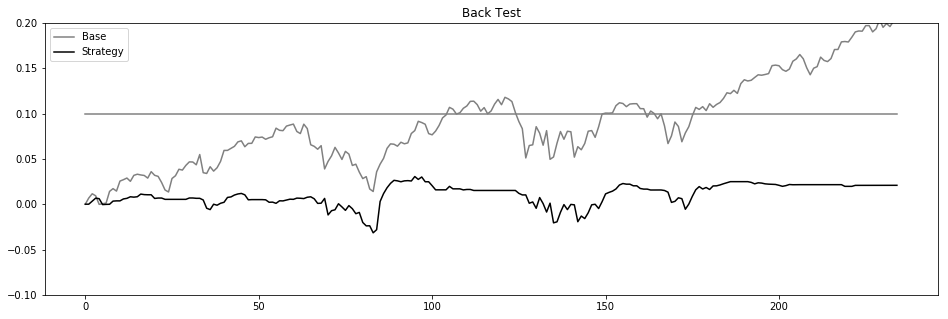

In [364]:
show_results(spc, allret)

In [382]:
# Both returns into same table.
spcr = []
for i in range(len(spc)):
    spcr.append(spc[i]/spc[0]-1)
    
final_return = pd.DataFrame({'strategy_Percentage': np.round(allret*100,2), 'benchmark_Percentage': np.round(np.array(spcr)*100,2)})
final_return.to_csv('final_return.csv')